In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import  linear_model

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from sklearn.model_selection import cross_val_score,RandomizedSearchCV,RepeatedKFold
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import time
import datetime

In [2]:
tripdata = pd.read_csv("../../dataset/final_bike_sharing.csv")

In [3]:
tripdata.columns

Index(['index', 'tripduration', 'start_station_id', 'start_station_name',
       'start_lat', 'start_lon', 'end_station_id', 'end_station_name',
       'end_lat', 'end_lon', 'bikeid', 'usertype', 'hour', 'min', 'temp',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'snow',
       'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'uvindex', 'conditions', 'date', 'dist',
       'birthyear', 'years_old', 'holiday', 'day', 'month', 'seasons',
       'gender'],
      dtype='object')

In [4]:
tripdata.shape

(315433, 39)

### Cols selected based on P value

In [5]:
selected_features = ['tripduration','start_lat','start_lon','end_lat','end_lon','usertype','hour',
                     'temp','feelslike','dew','snowdepth','winddir','sealevelpressure','visibility','solarradiation',
                     'conditions','dist','birthyear','holiday','day','month','gender']


In [6]:
df = tripdata[selected_features]

In [7]:
df.columns

Index(['tripduration', 'start_lat', 'start_lon', 'end_lat', 'end_lon',
       'usertype', 'hour', 'temp', 'feelslike', 'dew', 'snowdepth', 'winddir',
       'sealevelpressure', 'visibility', 'solarradiation', 'conditions',
       'dist', 'birthyear', 'holiday', 'day', 'month', 'gender'],
      dtype='object')

### Split the data into train and test

In [8]:
def split_dataset(df):
    X = df.drop('tripduration', axis=1)
    y = df['tripduration']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('Train', X_train.shape, y_train.shape)
    print('Test', X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

### One hot encoding for categorical values on Train

In [9]:
def one_hot_encoding(X_train, X_test):
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
    ohe = OneHotEncoder(drop='first', sparse=False)
    X_train_encoded = ohe.fit_transform(X_train[categorical_features])
    X_test_encoded = ohe.fit_transform(X_test[categorical_features])
    X_train_new = np.hstack((X_train[numerical_cols].values, X_train_encoded))
    X_test_new = np.hstack((X_test[numerical_cols].values, X_test_encoded))
    return X_train_new, X_test_new

## Apply LassoRegression

In [15]:
X_train, X_test, y_train, y_test = split_dataset(df)
X_train_encoded , X_test_encoded =  one_hot_encoding(X_train, X_test)
model_lasso = linear_model.LassoCV(eps=0.001, n_alphas=100,fit_intercept=True,max_iter=100).fit(X_train_encoded, y_train) 
print("Lasso Intercept is", model_lasso.intercept_)
print("Lasso coeffients are ", model_lasso.coef_)
print("Lasso model score is ", model_lasso.score(X_test_encoded, y_test))
y_pred = model_lasso.predict(X_test_encoded)
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

Train (252346, 21) (252346,)
Test (63087, 21) (63087,)
Lasso Intercept is 19.752586184431614
Lasso coeffients are  [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  4.18587363e-02  1.30947235e-02  0.00000000e+00  1.46484149e-03
  0.00000000e+00 -1.14358930e-04  2.84961262e-03  0.00000000e+00
  6.34015176e-04  4.66888866e+00 -1.02150075e-02 -6.85276483e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  9.31667904e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.37405076e-01  0.00000000e+00]
Lasso model score is  0.5104472535461939
        Actual  Predicted     Error
307061   14.42   8.202773  6.217227
96083     3.97   4.518506 -0.548506
178745    5.67   8.383954 -2.713954
83279     3.73   4.781667 -1.051667
108568    4.18   4.832042 -0.652042
...        ...        ...       ...
301551   13.33   7.779044  5.550956
24

In [16]:
print("MAE is ",mean_absolute_error(y_test, y_pred))
print("RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))
print("MSE is ", mean_squared_error(y_test, y_pred))

MAE is  1.6197664829805671
RMSE is 2.275336417761596
R2 error is  0.5104472535461939
MSE is  5.177155813992171


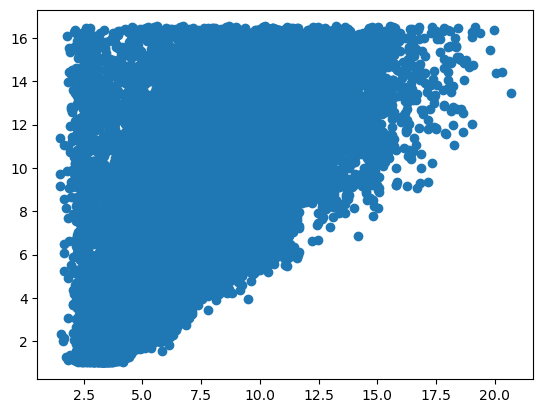

In [17]:
plt.scatter(y_pred, y_test)

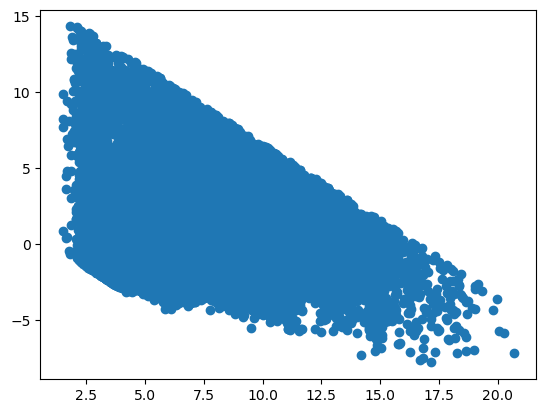

In [18]:
plt.scatter(y_pred,error)

plt.show()

## Apply LinearRegression

In [10]:
X_train, X_test, y_train, y_test = split_dataset(df)
X_train_encoded , X_test_encoded =  one_hot_encoding(X_train, X_test)
model_lr = linear_model.LinearRegression(fit_intercept=True).fit(X_train_encoded, y_train) 
print("LinearRegression model intercept is ", model_lr.intercept_)
print("LinearRegression model coef are ",model_lr.coef_)
print("LinearRegression model score is ", model_lr.score(X_test_encoded, y_test))
y_pred = model_lr.predict(X_test_encoded)
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

Train (252346, 21) (252346,)
Test (63087, 21) (63087,)
LinearRegression model intercept is  -552.217061285772
LinearRegression model coef are  [ 5.53646949e+00  1.48623666e+01  9.79083902e+00 -1.42070485e+01
  3.44088298e-02  3.50417774e-02 -1.72324293e-02  4.26308969e-03
  2.12325680e-01 -3.82600772e-05  1.72673475e-03  2.19342669e-02
  4.24774251e-04  4.96698133e+00 -1.04763348e-02 -2.58837199e+00
  1.36356502e+00  6.68002038e-03  3.81304849e-01 -4.14437884e-01
  4.36311680e-01 -1.32138924e-01  1.06438693e-01 -1.16573215e-02
  1.10752121e-01 -6.09408041e-02 -3.83437651e-03 -3.10051787e-02
  4.74918118e-02  3.17126659e-02  4.90060275e-02  2.87729070e-02
 -4.63925734e-01 -1.85578437e-01]
LinearRegression model score is  0.5272377063160185
        Actual  Predicted     Error
307061   14.42   8.515529  5.904471
96083     3.97   4.065051 -0.095051
178745    5.67   8.200672 -2.530672
83279     3.73   4.595647 -0.865647
108568    4.18   4.473330 -0.293330
...        ...        ...       ...

In [11]:
print("LinearRegression MAE is ",mean_absolute_error(y_test, y_pred))
print("LinearRegression RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("LinearRegression R2 error is " ,r2_score(y_test, y_pred))
print("LinearRegression model MSE is ", mean_squared_error(y_test, y_pred))

LinearRegression MAE is  1.5723178541140206
LinearRegression RMSE is 2.2359767726747313
LinearRegression R2 error is  0.5272377063160185
LinearRegression model MSE is  4.999592127940907


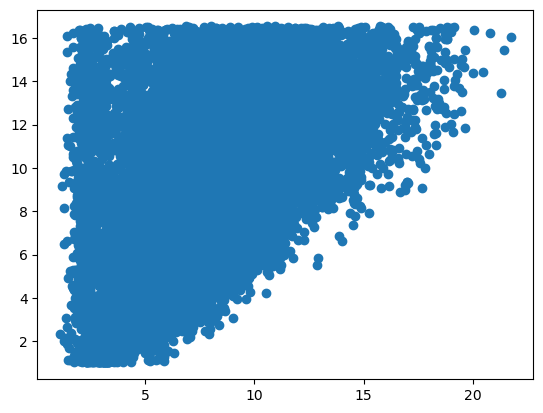

In [21]:
plt.scatter(y_pred, y_test)


plt.show()

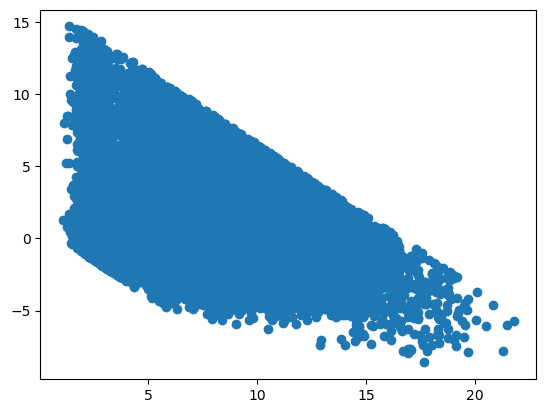

In [22]:
plt.scatter(y_pred,error)

plt.show()

## Apply Ridge Regresssion

In [24]:
X_train, X_test, y_train, y_test = split_dataset(df)
X_train_encoded , X_test_encoded =  one_hot_encoding(X_train, X_test)
model_rr = linear_model.RidgeCV(cv=5,alphas=(0.1, 0.01, 0.1),fit_intercept=True).fit(X_train_encoded, y_train)
print("Ridge Regression model intercept is ",model_rr.intercept_)
print("Ridge Regression model coef are ", model_rr.coef_)
print("Ridge Regression model score is ", model_rr.score(X_test_encoded, y_test))
y_pred = model_rr.predict(X_test_encoded)
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

Train (252346, 21) (252346,)
Test (63087, 21) (63087,)
Ridge Regression model intercept is  -552.0368386070354
Ridge Regression model coef are  [ 5.53637152e+00  1.48447116e+01  9.78025854e+00 -1.41928358e+01
  3.44160669e-02  3.50438845e-02 -1.72321042e-02  4.26151393e-03
  2.12329516e-01 -3.82684626e-05  1.72652444e-03  2.19333822e-02
  4.24769873e-04  4.96693444e+00 -1.04764105e-02 -2.58835995e+00
  1.36290383e+00  6.68550461e-03  3.81310415e-01 -4.14433052e-01
  4.36302990e-01 -1.32148112e-01  1.06446955e-01 -1.16487628e-02
  1.10761848e-01 -6.09488619e-02 -3.84284791e-03 -3.10001545e-02
  4.74826658e-02  3.17174356e-02  4.90042357e-02  2.87690015e-02
 -4.63924500e-01 -1.85584654e-01]
Ridge Regression model score is  0.5272379220934795
        Actual  Predicted     Error
307061   14.42   8.515752  5.904248
96083     3.97   4.065127 -0.095127
178745    5.67   8.200852 -2.530852
83279     3.73   4.595662 -0.865662
108568    4.18   4.473476 -0.293476
...        ...        ...       ..

In [25]:
print("Ridge Regression model MAE is ",mean_absolute_error(y_test, y_pred))
print("Ridge Regression model RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Ridge Regression model R2 error is " ,r2_score(y_test, y_pred))
print("Ridge Regression model MSE is ", mean_squared_error(y_test, y_pred))

Ridge Regression model MAE is  1.5723163608334696
Ridge Regression model RMSE is 2.235976262404081
Ridge Regression model R2 error is  0.5272379220934795
Ridge Regression model MSE is  4.999589846034524


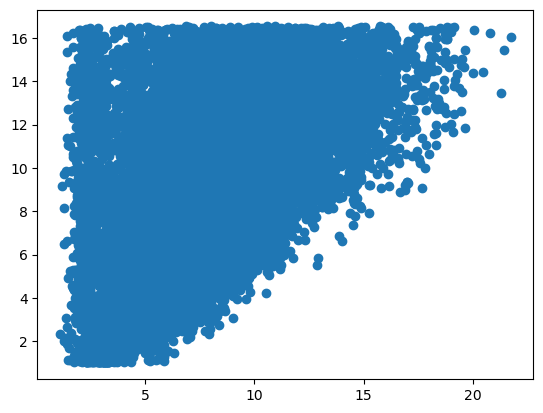

In [26]:
plt.scatter(y_pred, y_test)
plt.show()

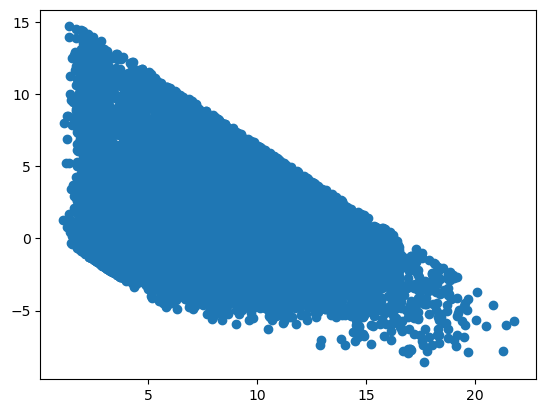

In [27]:
plt.scatter(y_pred,error)

plt.show()

### Apply GradientBoostingRegressor

In [31]:
reg = GradientBoostingRegressor(random_state=0)
X_train, X_test, y_train, y_test = split_dataset(df)
X_train_encoded , X_test_encoded =  one_hot_encoding(X_train, X_test)
reg.fit(X_train_encoded, y_train)
GradientBoostingRegressor(random_state=0)

Train (252346, 21) (252346,)
Test (63087, 21) (63087,)


GradientBoostingRegressor(random_state=0)

In [32]:
y_pred = reg.predict(X_test_encoded)
print("MAE of GBR simple" , mean_absolute_error(y_test, y_pred))
print("Gradient Boosting model score", reg.score(X_test_encoded, y_test))
print("Gradient Boosting RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Gradient Boosting R2 error is " ,r2_score(y_test, y_pred))
print("Gradient Boosting model MSE is ", mean_squared_error(y_test, y_pred))

MAE of GBR simple 1.3273652353062444
Gradient Boosting model score 0.6430007082171781
Gradient Boosting RMSE is 1.9430301945130595
Gradient Boosting R2 error is  0.6430007082171781
Gradient Boosting model MSE is  3.7753663367894577


### Choose best estimators

In [34]:
regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
regressor.fit(X_train_encoded, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [35]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test_encoded)]
best_n_estimators = np.argmin(errors)

In [36]:
best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(X_train_encoded, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

In [38]:
y_pred = best_regressor.predict(X_test_encoded)
print("MAE of GBR simple" , mean_absolute_error(y_test, y_pred))
print("Gradient Boosting model score", best_regressor.score(X_test_encoded, y_test))
print("RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))
print("Gradient Boosting model MSE is ", mean_squared_error(y_test, y_pred))

MAE of GBR simple 1.5805390982504075
Gradient Boosting model score 0.5476845445774106
RMSE is 2.1870896536582274
R2 error is  0.5476845445774106
Gradient Boosting model MSE is  4.783361153138865


In [39]:
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print("Actual Vs Prected Vs Error",df_preds)

Actual Vs Prected Vs Error         Actual  Predicted     Error
307061   14.42   8.445269  5.974731
96083     3.97   3.951460  0.018540
178745    5.67   8.445269 -2.775269
83279     3.73   3.951460 -0.221460
108568    4.18   3.951460  0.228540
...        ...        ...       ...
301551   13.33   8.445269  4.884731
245016    8.08  11.508506 -3.428506
161352    5.23   3.951460  1.278540
127041    4.52   5.710160 -1.190160
140892    4.80   5.710160 -0.910160

[63087 rows x 3 columns]


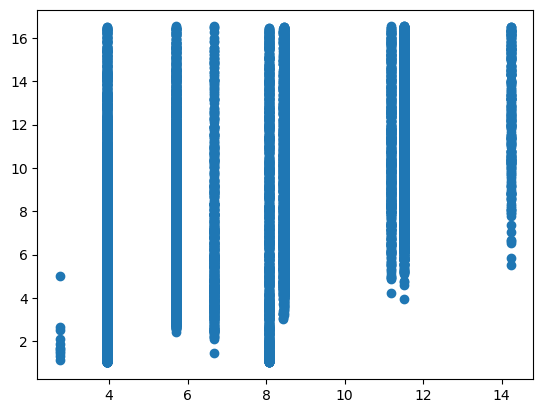

In [40]:
plt.scatter(y_pred, y_test)
plt.show()

In [41]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
gbc = GradientBoostingRegressor(**params)
gbc.fit(X_train_encoded,y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='ls', max_depth=4,
                          min_samples_split=5, n_estimators=500)

In [42]:
gbc.feature_importances_

array([1.31760824e-02, 7.51034317e-03, 1.73236618e-02, 5.49531176e-03,
       8.11127410e-03, 1.25590615e-03, 1.37094926e-03, 4.67621895e-06,
       1.06924368e-04, 3.56937978e-05, 3.16812046e-06, 0.00000000e+00,
       4.10774040e-04, 8.99646099e-01, 4.33906101e-03, 2.84919564e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.03368912e-05,
       2.71952458e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.98546792e-03, 2.78908995e-06])

In [43]:
y_pred = gbc.predict(X_test_encoded)

In [44]:
print("MAE is ", mean_absolute_error(y_test, y_pred))
print("Gradient Boosting model score", gbc.score(X_test_encoded, y_test))
print("RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))
print("model MSE is ", mean_squared_error(y_test, y_pred))

MAE is  1.335283211536213
Gradient Boosting model score 0.6418182510022967
RMSE is 1.9462453979830177
R2 error is  0.6418182510022967
model MSE is  3.7878711491700745


In [45]:
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

        Actual  Predicted     Error
307061   14.42   8.927591  5.492409
96083     3.97   4.402868 -0.432868
178745    5.67   8.419535 -2.749535
83279     3.73   4.281837 -0.551837
108568    4.18   4.459949 -0.279949
...        ...        ...       ...
301551   13.33   9.295371  4.034629
245016    8.08  11.880471 -3.800471
161352    5.23   3.331605  1.898395
127041    4.52   5.287964 -0.767964
140892    4.80   5.528869 -0.728869

[63087 rows x 3 columns]


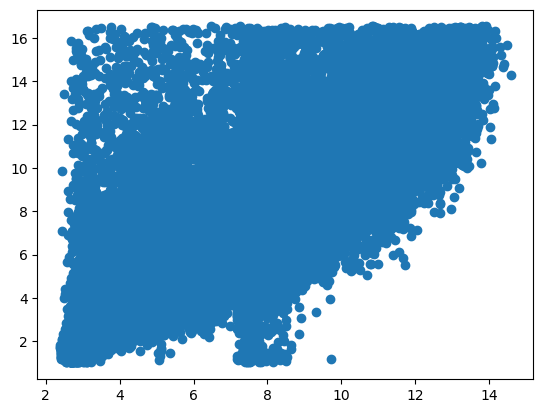

In [46]:
plt.scatter(y_pred, y_test)
plt.show()

### Gradient Boosting Regressor with GridSearchCV

In [47]:
X_test = X_test_encoded
X_train = X_train_encoded

In [48]:
# Number of trees
n_estimators = [50,100]

# Maximum depth of trees
max_depth = [4,6]

# Minimum number of samples required to split a node
min_samples_split = [50,100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [49]:
param_dict

{'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'min_samples_split': [50, 100],
 'min_samples_leaf': [40, 50]}

In [50]:
## Importing Gradient Boosting Regressor
from sklearn.model_selection import GridSearchCV
## Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_dict,
                       cv = 2, verbose=2)

fgb_model= gb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time= 1.8min
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=  59.7s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time= 2.4min
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time= 1.9min
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=  59.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time= 1.2min
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time= 1.8min
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time= 2.5min
[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time= 1.2min
[CV] END max_depth=4, 

In [51]:
gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=6, min_samples_leaf=50,
                          min_samples_split=50)

In [52]:
gb_optimal_model = gb_grid.best_estimator_

In [53]:
gb_grid.best_params_

{'max_depth': 6,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 100}

In [54]:
# Making predictions on train and test data
y_pred_train_g_g = gb_optimal_model.predict(X_train)
y_pred_g_g= gb_optimal_model.predict(X_test)

In [55]:
r2_score(y_train, y_pred_train_g_g)

0.6937813280633648

In [56]:
gradient=r2_score(y_test, y_pred_g_g)
gradient

0.6839097767559088

In [57]:
print("MAE is ",mean_absolute_error(y_test, y_pred_g_g))
print("RMSE is ", np.sqrt(mean_squared_error(y_test, y_pred_g_g)))
print("R2 error is " ,r2_score(y_test, y_pred_g_g))
# print("XGBoost model score ", xgb_r.score(X_test, y_test))

MAE is  1.2126142797167625
RMSE is  1.8283166061587501
R2 error is  0.6839097767559088


Text(0.5, 0, 'Actual Values')

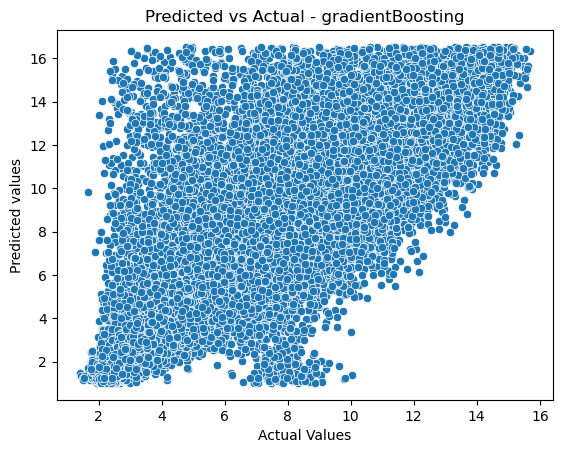

In [58]:
#visualizing the predictions
sns.scatterplot(x=y_pred_g_g,y=y_test)
plt.title('Predicted vs Actual - gradientBoosting')
plt.ylabel('Predicted values')
plt.xlabel('Actual Values')

### Apply XGBOST

In [59]:
#!pip install xgboost

In [60]:
import xgboost as xg

In [61]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
y_pred = xgb_r.predict(X_test)
 

In [62]:
print("MAE is ",mean_absolute_error(y_test, y_pred))
print("RMSE is ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))
print("XGBoost model score ", xgb_r.score(X_test, y_test))
print("MSE is ", mean_squared_error(y_test, y_pred))

MAE is  1.269520607682595
RMSE is  1.9161666260866523
R2 error is  0.6528039312987712
XGBoost model score  0.6528039312987712
MSE is  3.671694538928304


In [63]:
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

        Actual  Predicted     Error
307061   14.42   8.595552  5.824448
96083     3.97   4.072320 -0.102320
178745    5.67   8.003125 -2.333125
83279     3.73   4.158541 -0.428541
108568    4.18   4.242204 -0.062204
...        ...        ...       ...
301551   13.33   8.589997  4.740003
245016    8.08  12.357883 -4.277883
161352    5.23   3.347417  1.882583
127041    4.52   4.907840 -0.387840
140892    4.80   5.528432 -0.728432

[63087 rows x 3 columns]


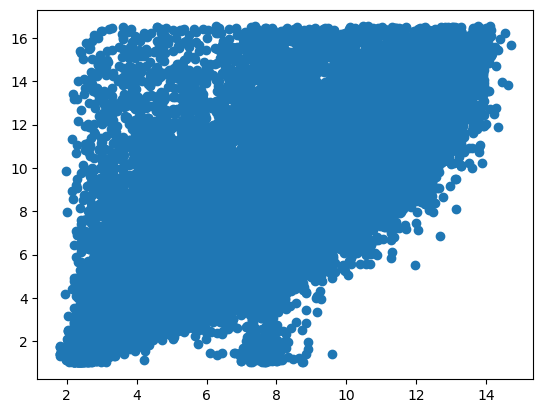

In [64]:
plt.scatter(y_pred, y_test)
plt.show()

### Apply XGBOST with hyperparameter optimization

In [65]:
params = { 'max_depth': [3, 5],
           'learning_rate': [0.01, 0.1],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500]}
xgbr = xg.XGBRegressor(seed = 20)

In [66]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=15,
                         verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}
Lowest RMSE:  1.8073678415231826


In [67]:
bestparameters= {'subsample': np.arange(0.7), 'n_estimators': [500], 'max_depth': [5], 'learning_rate':[0.1], 'colsample_bytree': np.arange(0.8999999999999999),'colsample_bylevel': np.arange(0.8999999999999999)}

In [68]:
clf = xg.XGBRegressor(objective ='reg:squarederror', seed = 20, n_estimators = 500, max_depth= 5, learning_rate= 0.1,
                      colsample_bytree = 0.89,colsample_bylevel= 0.79)

clf.fit(X_train, y_train)
# Predict the model
y_pred = clf.predict(X_test)

In [69]:
print("MAE is ",mean_absolute_error(y_test, y_pred))
print("RMSE is ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))
print("XGBoost model score ", clf.score(X_test, y_test))
print("MSE is ", mean_squared_error(y_test, y_pred))

MAE is  1.1616993795972632
RMSE is  1.780296726486419
R2 error is  0.7002956530683377
XGBoost model score  0.7002956530683377
MSE is  3.1694564343382594


In [70]:
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

        Actual  Predicted     Error
307061   14.42   9.837934  4.582066
96083     3.97   4.163856 -0.193856
178745    5.67   7.454673 -1.784673
83279     3.73   4.087543 -0.357543
108568    4.18   4.659374 -0.479374
...        ...        ...       ...
301551   13.33   9.514215  3.815785
245016    8.08  11.206318 -3.126318
161352    5.23   3.355050  1.874950
127041    4.52   5.279899 -0.759899
140892    4.80   6.055843 -1.255843

[63087 rows x 3 columns]


## Random Forest 

In [71]:
def rf_train(X_train, y_train):
    print(datetime.datetime.now())
    rf_reg = RandomForestRegressor(n_estimators=250, random_state = 100, verbose=2)
    model_reg = rf_reg.fit(X_train, y_train)
    print(datetime.datetime.now())
    return model_reg

In [72]:
rf_src = rf_train(X_train, y_train)

2023-03-11 19:32:23.567287
building tree 1 of 250


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 21.4min finished


2023-03-11 19:53:49.608157


In [73]:
# Predict the model
y_pred = rf_src.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   54.7s finished


In [74]:
print("MAE is ",mean_absolute_error(y_test, y_pred))
print("MSE is ", mean_squared_error(y_test, y_pred))
print("RMSE is ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))
print("RF model score ", rf_src.score(X_test, y_test))

MAE is  1.1007170395172141
MSE is  2.979300545797077
RMSE is  1.7260650468035894
R2 error is  0.7182768266768477


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


RF model score  0.7182768266768477


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   52.9s finished


In [75]:
error = y_test - y_pred
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze(), 'Error': error.squeeze()})
print(df_preds)

        Actual  Predicted     Error
307061   14.42  11.795280  2.624720
96083     3.97   3.949480  0.020520
178745    5.67   6.137200 -0.467200
83279     3.73   3.669107  0.060893
108568    4.18   4.851440 -0.671440
...        ...        ...       ...
301551   13.33   9.143240  4.186760
245016    8.08  12.406680 -4.326680
161352    5.23   3.875060  1.354940
127041    4.52   5.295960 -0.775960
140892    4.80   5.373720 -0.573720

[63087 rows x 3 columns]


### BootStrap on Full data Linear Regression

In [13]:
features = ['start_lat','start_lon','end_lat','end_lon','usertype','hour',
                     'temp','feelslike','dew','snowdepth','winddir','sealevelpressure','visibility','solarradiation',
                     'conditions','dist','birthyear','holiday','day','month','gender']

In [15]:
bootstrap_data ={}

X_train, X_test, y_train, y_test = split_dataset(df)
X_train, X_test = one_hot_encoding(X_train,X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
model_lr = LinearRegression(fit_intercept=True)
rng = np.random.RandomState(1234)
idx_train = np.arange(y_train.shape[0])
idx_test = np.arange(y_test.shape[0])
bootstarp_train_accuracies = {}
print(f"started bootstrap run is ", datetime.datetime.now())

for i in range(501):
    train_idx = rng.choice(idx_train, size=idx_train.shape[0], replace=True)
    test_idx = rng.choice(idx_test, size=idx_test.shape[0], replace=True)

    boot_train_X, boot_train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]

    boot_test_X, boot_test_y = X_test.iloc[test_idx], y_test.iloc[test_idx]

    model_lr.fit(boot_test_X, boot_test_y )
    boot_y_pred = model_lr.predict(boot_test_X)
    bootstarp_train_accuracies[i] = {"RMSE": np.sqrt(mean_squared_error(boot_test_y, boot_y_pred)),
                                  "R2":r2_score(boot_test_y, boot_y_pred), "intercept":model_lr.intercept_}
print(f"stopped bootstrap run is ", datetime.datetime.now())  

R2 = []
RMSE = []
intercept = []
for i in range(501):
    R2.append(bootstarp_train_accuracies[i]['R2'])
    RMSE.append(bootstarp_train_accuracies[i]['RMSE'])
    intercept.append(bootstarp_train_accuracies[i]['intercept'])

Train (252346, 21) (252346,)
Test (63087, 21) (63087,)
started bootstrap run is  2023-03-21 16:29:32.605283
stopped bootstrap run is  2023-03-21 16:34:40.963138


In [18]:
print("R2", [np.percentile(R2, 2.5), np.percentile(R2, 97.5)])
print("RMSE",[np.percentile(RMSE, 2.5), np.percentile(RMSE, 97.5)])

R2 [0.5197428996061007, 0.5358435016216616]
RMSE [2.2081787852616945, 2.255565277182137]
